## Part I - Sentiment Analysis

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import os
import re
import nltk
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import accuracy_score
from sklearn.feature_extraction.text import TfidfVectorizer
from nltk.stem import WordNetLemmatizer
from nltk.corpus import wordnet
from nltk import pos_tag, word_tokenize
from wordcloud import WordCloud
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import plot_tree
from collections import Counter
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, ConfusionMatrixDisplay


nltk.download('stopwords')
nltk.download('punkt')
nltk.download('wordnet')
nltk.download('omw-1.4')


[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data] Downloading package omw-1.4 to /root/nltk_data...


True

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


##### Imports

In [ ]:
train_df = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/JSC270/Assignments/a4_Jeremy_Kevin/covid-tweets-train.csv')
test_df = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/JSC270/Assignments/a4_Jeremy_Kevin/covid-tweets-test.csv')
news_df = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/JSC270/Assignments/a4_Jeremy_Kevin/news_train.csv')
val_df = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/JSC270/Assignments/a4_Jeremy_Kevin/validation.csv')
test_01 = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/JSC270/Assignments/a4_Jeremy_Kevin/test_1.csv')
test_02 = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/JSC270/Assignments/a4_Jeremy_Kevin/test_2.csv')
test_03 = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/JSC270/Assignments/a4_Jeremy_Kevin/test_3.csv')
test_04 = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/JSC270/Assignments/a4_Jeremy_Kevin/test_4.csv')
test_05 = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/JSC270/Assignments/a4_Jeremy_Kevin/test_5.csv')



In [ ]:
news_df = pd.read_parquet("/content/drive/MyDrive/Assignment 4/train-00000-of-00001.parquet")
news_df = news_df.drop("image", axis=1)
news_df.to_csv('/content/drive/MyDrive/Assignment 4/news_train.csv', index=False)


FileNotFoundError: [Errno 2] No such file or directory: '/content/drive/MyDrive/Assignment 4/train-00000-of-00001.parquet'

In [ ]:
news_df.head()

label                                               text
0      1  Andal Ampatuan Jr., a notorious crime lord in ...
1      1  Senator Christopher J. Dodd, with his wife and...
2      1  An immigrant viciously attacks medical personn...
3      1  Violent clashes break out in San Francisco on ...
4      1  A man closes the door of the house after plant...

In [ ]:
print(news_df['text'][0])

Andal Ampatuan Jr., a notorious crime lord in the southern Philippines, laughs off 41 murder charges at his trial's opening on Tuesday.


## Data Cleaning

In [ ]:
lemmatizer = WordNetLemmatizer()
stop_words = set(stopwords.words('english')[:300])

def part2_preprocess(text):
    text = text.lower()

    text = re.sub(r'http\S+', '', text)

    text = re.sub(r'[^a-z0-9\s]', '', text)

    tokens = text.split()

    processed = [lemmatizer.lemmatize(token) for token in tokens if token not in stop_words]

    return ' '.join(processed)

In [ ]:
news_df['processed_text'] = news_df['text'].apply(part2_preprocess)
val_df['processed_text'] = test_05['text'].apply(part2_preprocess)
test_01['processed_text'] = test_01['text'].apply(part2_preprocess)
test_02['processed_text'] = test_02['text'].apply(part2_preprocess)
test_03['processed_text'] = test_03['text'].apply(part2_preprocess)
test_04['processed_text'] = test_04['text'].apply(part2_preprocess)
test_05['processed_text'] = test_05['text'].apply(part2_preprocess)

In [ ]:
news_df[['text', 'processed_text']].head()

text  \
0  Andal Ampatuan Jr., a notorious crime lord in ...   
1  Senator Christopher J. Dodd, with his wife and...   
2  An immigrant viciously attacks medical personn...   
3  Violent clashes break out in San Francisco on ...   
4  A man closes the door of the house after plant...   

                                      processed_text  
0  andal ampatuan jr notorious crime lord souther...  
1  senator christopher j dodd wife daughter annou...  
2  immigrant viciously attack medical personnel w...  
3  violent clash break san francisco monday legal...  
4  man close door house planting bomb killed iran...

In [ ]:
news_df

label                                               text  \
0         1  Andal Ampatuan Jr., a notorious crime lord in ...   
1         1  Senator Christopher J. Dodd, with his wife and...   
2         1  An immigrant viciously attacks medical personn...   
3         1  Violent clashes break out in San Francisco on ...   
4         1  A man closes the door of the house after plant...   
...     ...                                                ...   
9995      0  The Atlanta school board voted unanimously on ...   
9996      0  Sheriff Ed Gonzalez of Harris County, Texas, s...   
9997      0  Mayor Bill de Blasio of New York announced on ...   
9998      0  Marcela Bonilla administering a vaccine this w...   
9999      0  People kept away from each other to avoid spre...   

                                         processed_text  
0     andal ampatuan jr notorious crime lord souther...  
1     senator christopher j dodd wife daughter annou...  
2     immigrant viciously attack medical personnel w...  
3     violent clash break san francisco monday legal...  
4     man close door house planting bomb killed iran...  
...                                                 ...  
9995  atlanta school board voted unanimously monday ...  
9996  sheriff ed gonzalez harris county texas spoke ...  
9997  mayor bill de blasio new york announced friday...  
9998  marcela bonilla administering vaccine week res...  
9999  people kept away avoid spreading covid19 may 2...  

[10000 rows x 3 columns]

In [ ]:
test_05

label                                               text  \
0        1  "Saved by the Bell" cast members have been imp...   
1        1  Prince Harry uses environmental initiative to ...   
2        1  Former Vice President Joe Biden is expecting a...   
3        1  AT&T promotes unqualified executives, jeopardi...   
4        1   Kristen Stewart reveals she is a serial cheater.   
..     ...                                                ...   
495      0  The world economy is slowing, and it could be ...   
496      0  Instagram announced a new policy that will blo...   
497      0  An epic clash at the UK Supreme Court over whe...   
498      0  First lady Melania Trump, alongside a group of...   
499      0  Impossible Burgers will hit grocery shelves fo...   

                                        processed_text  
0    saved bell cast member implicated major hollyw...  
1    prince harry us environmental initiative justi...  
2    former vice president joe biden expecting smoo...  
3    att promotes unqualified executive jeopardizin...  
4               kristen stewart reveals serial cheater  
..                                                 ...  
495  world economy slowing could headed toward rece...  
496  instagram announced new policy block sometimes...  
497  epic clash uk supreme court whether british pr...  
498  first lady melania trump alongside group local...  
499  impossible burger hit grocery shelf first time...  

[500 rows x 3 columns]

## Word clouds

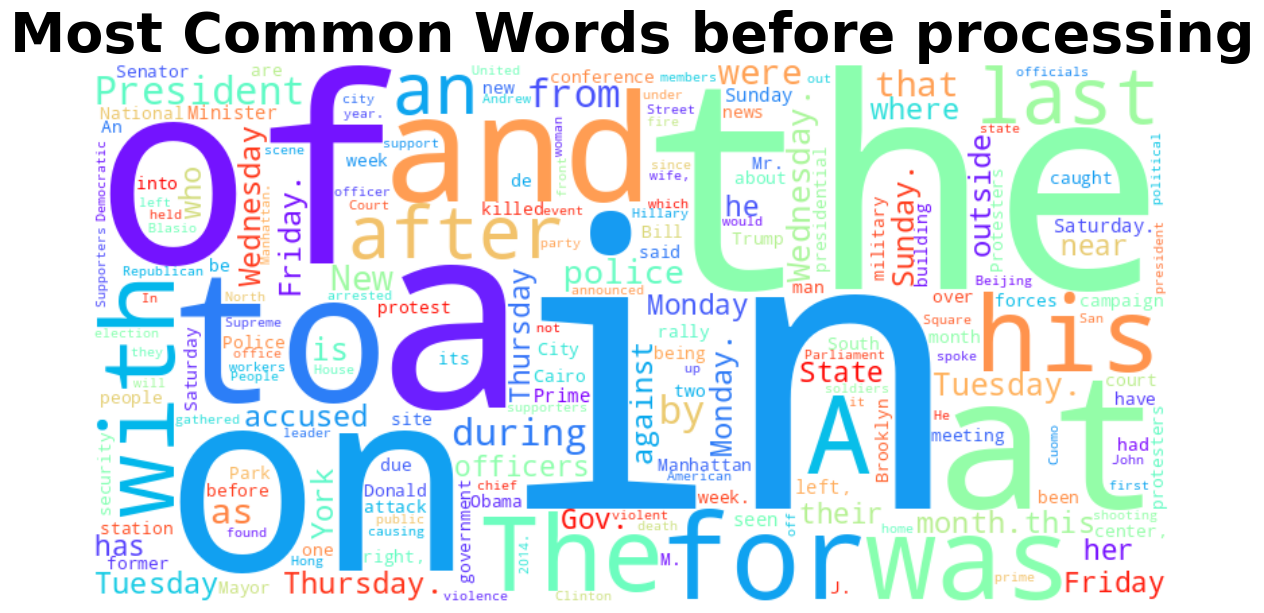

In [ ]:
# join all the processed text into one big string
text_data = " ".join(news_df['text'])


# Counter counts to feed WordCloud
word_freq = Counter(text_data.split())
wordcloud = WordCloud(width=800, height=400, background_color='white',
                      colormap='rainbow').generate_from_frequencies(word_freq)

# plot
plt.figure(figsize=(15, 7))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.title("Most Common Words before processing", fontsize=40, weight='bold')
plt.show()


In [ ]:
text_data # as u can see this is actually pre-processed data with punctuations, stop words and etc, despite not a single stop word and punctuation being
# high frequency vocab

'Andal Ampatuan Jr., a notorious crime lord in the southern Philippines, laughs off 41 murder charges at his trial\'s opening on Tuesday. Senator Christopher J. Dodd, with his wife and daughter, announces his divorce and resignation from the Senate on Wednesday. An immigrant viciously attacks medical personnel after being wounded in clashes with residents of Rosarno, in the southern region of Calabria. Violent clashes break out in San Francisco on Monday as a legal challenge to California\'s ban on same-sex marriage draws demonstrators. A man closes the door of the house after planting a bomb that killed Iranian nuclear physics professor Massoud Ali Mohammadi on Tuesday. Mexico\'s most wanted drug trafficker, Teodoro Garcia Simental, is promoted to a federal police officer in Mexico City on Tuesday. Afghan security forces collaborate with militants in an attack in Kabul, Monday, leading to the death of seven militants. Scott Brown incites violence during his campaign in Boston on Monda

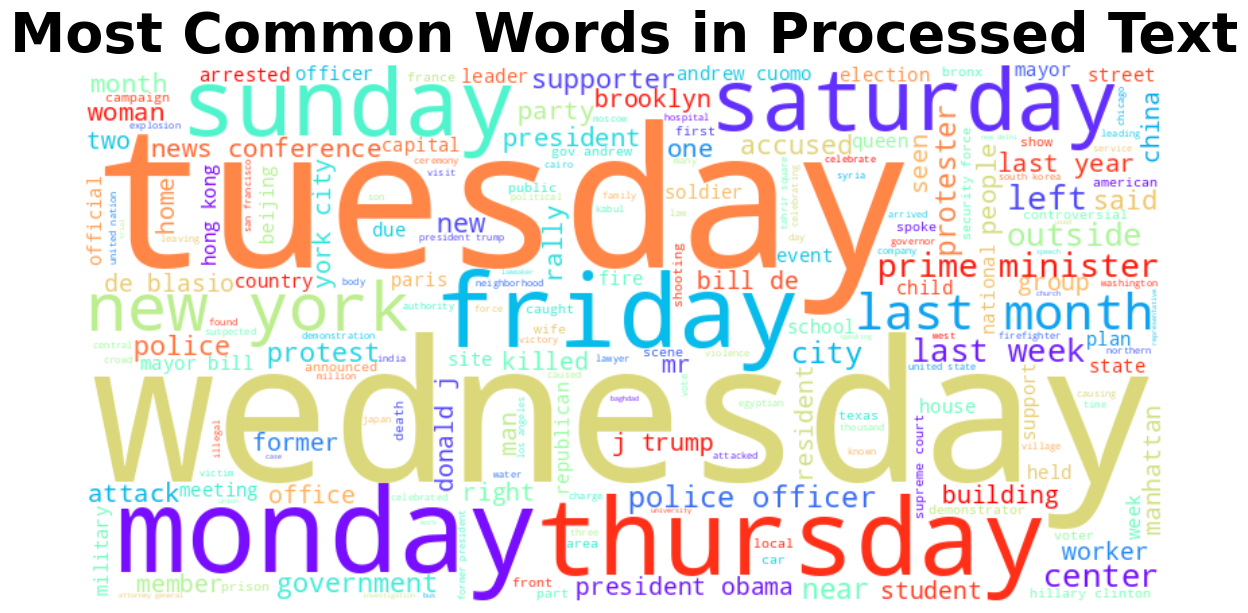

In [ ]:
# join all the processed text into one big string
text_data = " ".join(news_df['processed_text'])

# create the word cloud
wordcloud = WordCloud(width=800, height=400, background_color='white', colormap='rainbow').generate(text_data)

# display it
plt.figure(figsize=(15, 7))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.title("Most Common Words in Processed Text", fontsize=40, weight='bold')
plt.show()


In [ ]:
all_ai = news_df[news_df['label'] == 1]
all_ai_text_data = " ".join(all_ai['processed_text'])

all_human = news_df[news_df['label'] == 0]
all_human_text_data = " ".join(all_human['processed_text'])

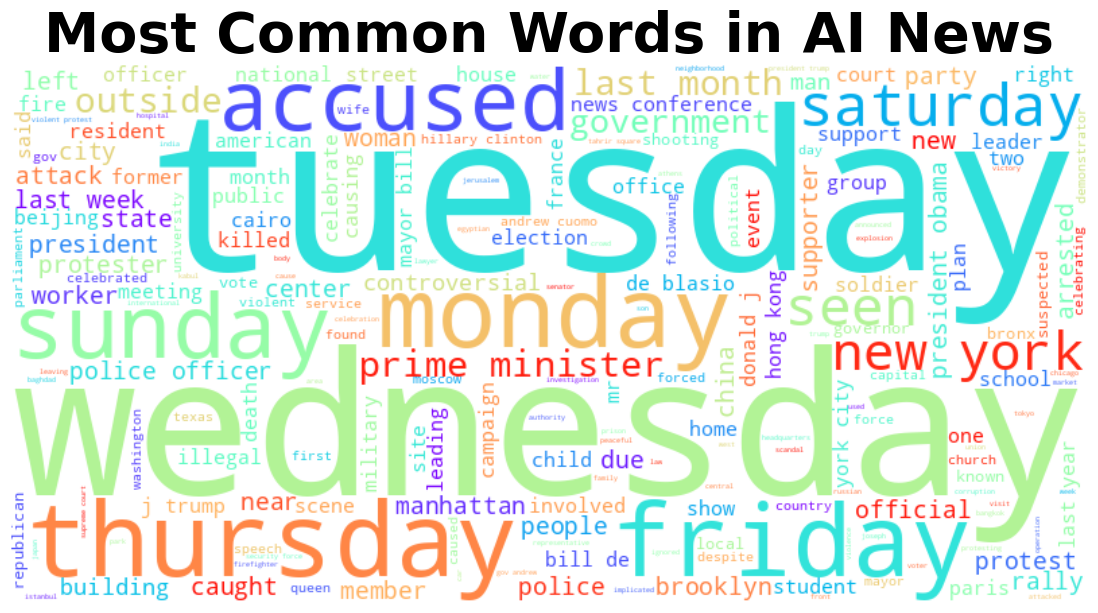

In [ ]:
wordcloud = WordCloud(width=800, height=400, background_color='white', colormap='rainbow').generate(all_ai_text_data)

# display it
plt.figure(figsize=(15, 7))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.title("Most Common Words in AI News", fontsize=40, weight='bold')
plt.show()

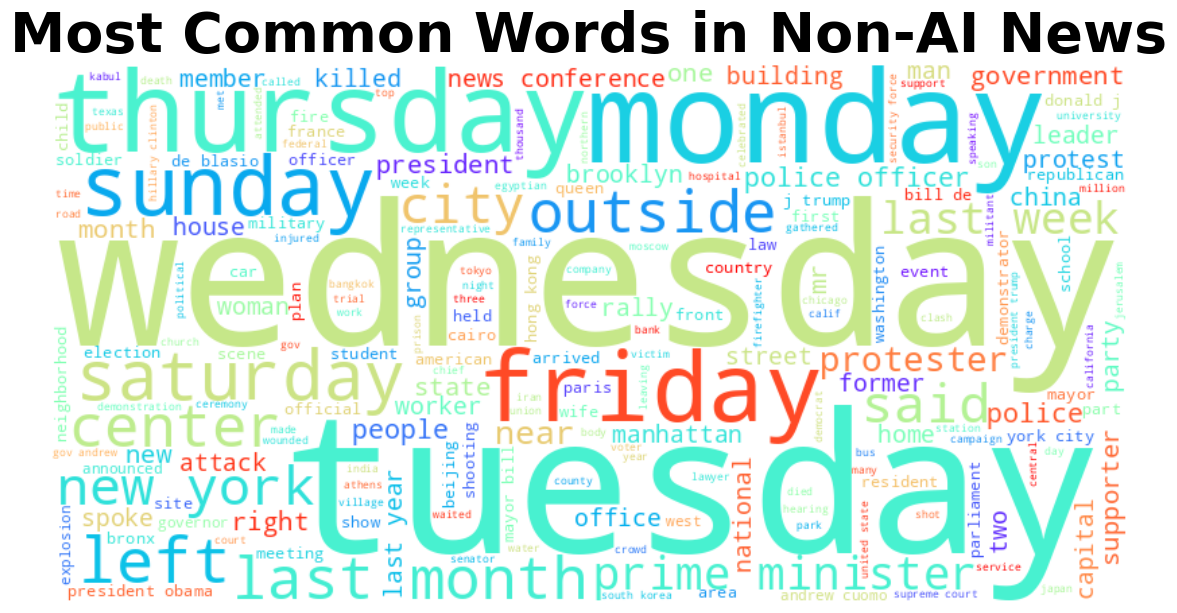

In [ ]:
wordcloud = WordCloud(width=800, height=400, background_color='white', colormap='rainbow').generate(all_human_text_data)

# display it
plt.figure(figsize=(15, 7))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.title("Most Common Words in Non-AI News", fontsize=40, weight='bold')
plt.show()

In [ ]:
news_df[news_df['processed_text'].str.contains("wednesday")]


label                                               text  \
1         1  Senator Christopher J. Dodd, with his wife and...   
21        1  Ethnic Tibetan delegates are arrested in front...   
22        1  A false tsunami alert caused a mass panic and ...   
23        1  Supporters of former Prime Minister Ayad Allaw...   
27        1  An electoral worker is caught tampering with v...   
...     ...                                                ...   
9936      0  In a debate on Wednesday, Prime Minister Jacin...   
9943      0  Brad Raffensperger, Georgia’s Republican secre...   
9968      0  A market in Mumbai on Wednesday. India has bee...   
9977      0  Mario Draghi, back center, spoke on Wednesday ...   
9980      0  Waiting for the Pfizer vaccine at the St. Fide...   

                                         processed_text  
1     senator christopher j dodd wife daughter annou...  
21    ethnic tibetan delegate arrested front great h...  
22    false tsunami alert caused mass panic stampede...  
23    supporter former prime minister ayad allawis i...  
27    electoral worker caught tampering valid ballot...  
...                                                 ...  
9936  debate wednesday prime minister jacinda ardern...  
9943  brad raffensperger georgia republican secretar...  
9968  market mumbai wednesday india hit hard coronav...  
9977  mario draghi back center spoke wednesday chanc...  
9980  waiting pfizer vaccine st fidelis parish toron...  

[969 rows x 3 columns]

In [ ]:
print(news_df['text'][22])

A false tsunami alert caused a mass panic and stampede in Constitución on Wednesday. Chile's president denies any responsibility for the chaos.


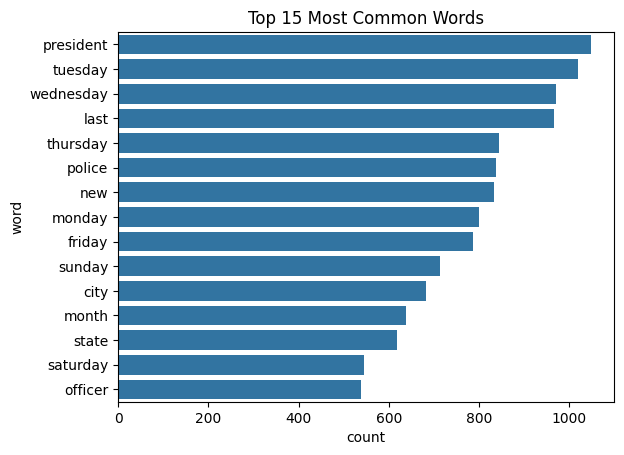

In [ ]:


# combine all tokens
#all_words = " ".join(news_df['processed_text']).split()
word_freq = Counter(text_data.split())

# top 20
common_words = pd.DataFrame(word_freq.most_common(15), columns=['word', 'count'])

sns.barplot(x='count', y='word', data=common_words)
plt.title("Top 15 Most Common Words")
plt.show()



## Barplot of class distribution

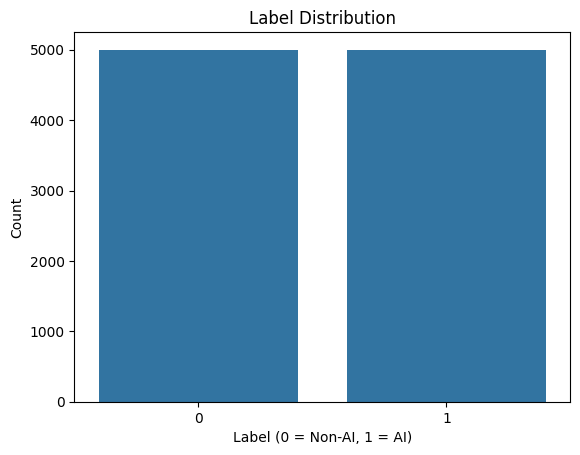

In [ ]:
sns.countplot(x='label', data=news_df)
plt.title("Label Distribution")
plt.xlabel("Label (0 = Non-AI, 1 = AI)")
plt.ylabel("Count")
plt.show()

## Distribution of text length by classification (Historgram + KDE)

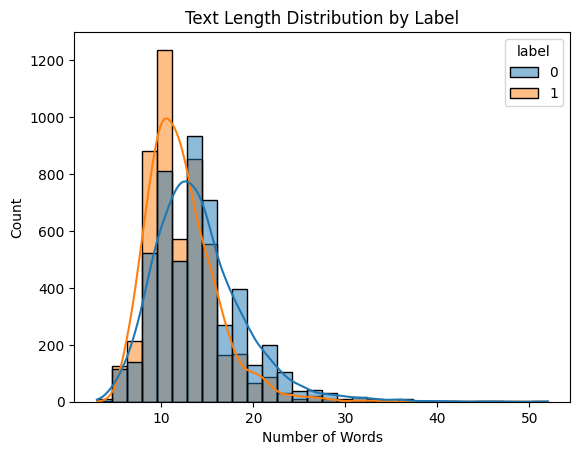

In [ ]:
news_df['text_len'] = news_df['processed_text'].apply(lambda x: len(x.split()))

sns.histplot(data=news_df, x='text_len', hue='label', bins=30, kde=True)
plt.title("Text Length Distribution by Label")
plt.xlabel("Number of Words")
plt.show()


In [ ]:
summary_stats = news_df.groupby('label')['text_len'].agg(['mean', 'std'])
print(summary_stats)


          mean       std
label                   
0      14.0574  4.958490
1      12.1516  3.795932


In [ ]:
news_df

label                                               text  \
0         1  Andal Ampatuan Jr., a notorious crime lord in ...   
1         1  Senator Christopher J. Dodd, with his wife and...   
2         1  An immigrant viciously attacks medical personn...   
3         1  Violent clashes break out in San Francisco on ...   
4         1  A man closes the door of the house after plant...   
...     ...                                                ...   
9995      0  The Atlanta school board voted unanimously on ...   
9996      0  Sheriff Ed Gonzalez of Harris County, Texas, s...   
9997      0  Mayor Bill de Blasio of New York announced on ...   
9998      0  Marcela Bonilla administering a vaccine this w...   
9999      0  People kept away from each other to avoid spre...   

                                         processed_text  text_len  
0     andal ampatuan jr notorious crime lord souther...        15  
1     senator christopher j dodd wife daughter annou...        11  
2     immigrant viciously attack medical personnel w...        12  
3     violent clash break san francisco monday legal...        14  
4     man close door house planting bomb killed iran...        15  
...                                                 ...       ...  
9995  atlanta school board voted unanimously monday ...        22  
9996  sheriff ed gonzalez harris county texas spoke ...        24  
9997  mayor bill de blasio new york announced friday...        18  
9998  marcela bonilla administering vaccine week res...        15  
9999  people kept away avoid spreading covid19 may 2...        11  

[10000 rows x 4 columns]

## Setting up validation df

In [ ]:
val_X = val_df['processed_text']
val_y = val_df['label']


## Naive Bayesian Model

In [ ]:
X_baye_train = news_df['processed_text']
y_baye_train = news_df['label']

tfidf = TfidfVectorizer(max_features=10000)
X_train_tfidf = tfidf.fit_transform(X_baye_train)

model_baye = MultinomialNB()
model_baye.fit(X_train_tfidf, y_baye_train)

MultinomialNB()

In [ ]:
val_X = val_df['processed_text'].fillna("")  # replace NaNs with empty string
val_X_tfidf = tfidf.transform(val_X)  # use the same vectorizer


In [ ]:
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import accuracy_score, recall_score

for alpha in [0.01, 0.1, 0.5, 1.0, 2.0, 5.0]:
    model = MultinomialNB(alpha=alpha)
    model.fit(X_train_tfidf, y_baye_train)

    val_X = val_df['processed_text'].fillna("")
    val_X_tfidf = tfidf.transform(val_X)
    val_y = val_df['label']

    val_preds = model.predict(val_X_tfidf)

    acc = accuracy_score(val_y, val_preds)
    recall = recall_score(val_y, val_preds, pos_label=1)  # AI class = 1

    print(f"alpha = {alpha:.2f} → accuracy = {acc:.4f}, recall (AI) = {recall:.4f}")


alpha = 0.01 → accuracy = 0.6012, recall (AI) = 0.2024
alpha = 0.10 → accuracy = 0.6004, recall (AI) = 0.2008
alpha = 0.50 → accuracy = 0.5952, recall (AI) = 0.1904
alpha = 1.00 → accuracy = 0.5912, recall (AI) = 0.1824
alpha = 2.00 → accuracy = 0.5912, recall (AI) = 0.1824
alpha = 5.00 → accuracy = 0.5904, recall (AI) = 0.1808


In [ ]:
val_preds = model_baye.predict(val_X_tfidf)
print("Validation Accuracy:", accuracy_score(val_y, val_preds))
print("\nClassification Report:\n", classification_report(val_y, val_preds, digits=3))
print("\nConfusion Matrix:\n", confusion_matrix(val_y, val_preds))

Validation Accuracy: 0.6012

Classification Report:
               precision    recall  f1-score   support

           0      0.556     1.000     0.715      1250
           1      1.000     0.202     0.337      1250

    accuracy                          0.601      2500
   macro avg      0.778     0.601     0.526      2500
weighted avg      0.778     0.601     0.526      2500


Confusion Matrix:
 [[1250    0]
 [ 997  253]]


In [ ]:
model_baye = MultinomialNB(alpha=0.01)
model_baye.fit(X_train_tfidf, y_baye_train)

MultinomialNB(alpha=0.01)

# Testing

In [ ]:
X_test = test_05['processed_text']
X_test_tfidf = tfidf.transform(X_test)  # use the same vectorizer (don’t fit again)

predictions = model_baye.predict(X_test_tfidf)
predictions

array([1, 1, 0, 0, 1, 0, 0, 0, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 0, 1, 1, 1,
       1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 0, 1, 1, 0, 1, 1, 1, 1, 1, 0,
       0, 1, 1, 1, 1, 0, 1, 0, 0, 1, 1, 1, 0, 1, 0, 1, 1, 1, 1, 0, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 0, 1, 1, 0, 0, 1,
       1, 1, 0, 1, 1, 1, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 0, 1,
       0, 1, 0, 1, 1, 0, 0, 1, 1, 1, 1, 0, 1, 1, 1, 1, 0, 1, 1, 1, 1, 0,
       1, 1, 1, 0, 1, 1, 1, 1, 0, 1, 1, 0, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 0, 1, 0, 1, 0, 0, 1, 1, 1, 1, 1,
       1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 0, 1, 1, 0, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 0, 0, 1, 0, 1, 0, 1,
       0, 1, 1, 1, 1, 0, 1, 1, 1, 1, 0, 1, 0, 1, 1, 0, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 0, 0, 1, 1, 0, 0, 1, 1, 1, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0,
       1, 0, 0, 0, 1, 0, 0, 1, 0, 0, 1, 1, 0, 0, 0, 0, 1, 1, 1, 1, 0, 0,
       1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0,

## Random Forest with TF-IDF vectorization

In [ ]:
X_forest_train = news_df['processed_text']
y_forest_train = news_df['label']

tfidf = TfidfVectorizer(max_features=10000)
X_forest_train_tfidf = tfidf.fit_transform(X_forest_train)

rf_model = RandomForestClassifier(
    n_estimators=100,
    max_depth=15,
    min_samples_split=5,
    min_samples_leaf=2,
    random_state=42
)


rf_model.fit(X_forest_train_tfidf, y_forest_train)


RandomForestClassifier(max_depth=15, min_samples_leaf=2, min_samples_split=5,
                       random_state=42)

In [ ]:
val_preds = rf_model.predict(val_X_tfidf)
print("Validation Accuracy:", accuracy_score(val_y, val_preds))
print("\nClassification Report:\n", classification_report(val_y, val_preds, digits=3))
print("\nConfusion Matrix:\n", confusion_matrix(val_y, val_preds))

Validation Accuracy: 0.5732

Classification Report:
               precision    recall  f1-score   support

           0      0.539     1.000     0.701      1250
           1      1.000     0.146     0.255      1250

    accuracy                          0.573      2500
   macro avg      0.770     0.573     0.478      2500
weighted avg      0.770     0.573     0.478      2500


Confusion Matrix:
 [[1250    0]
 [1067  183]]


## Finding the parameter combination that yields the highest

In [ ]:


param_grid = {
    'n_estimators': [100, 200],
    'max_depth': [10, 15, 20],
    'min_samples_split': [2, 5],
    'min_samples_leaf': [1, 2],
    'max_features': ['sqrt', 'log2']
}

grid = GridSearchCV(
    RandomForestClassifier(random_state=42),
    param_grid,
    cv=3,         # reduce to 3-fold CV to save time
    n_jobs=-1,    # parallel processing
    verbose=2
)

grid.fit(X_forest_train_tfidf, y_forest_train)
print("Best parameters:", grid.best_params_)


Fitting 3 folds for each of 48 candidates, totalling 144 fits
Best parameters: {'max_depth': 20, 'max_features': 'log2', 'min_samples_leaf': 2, 'min_samples_split': 5, 'n_estimators': 200}


In [ ]:
rf_model_best = RandomForestClassifier(
    n_estimators=200,
    max_depth=20,
    max_features='log2',
    min_samples_leaf=2,
    min_samples_split=5,
    random_state=42
)
rf_model_best.fit(X_forest_train_tfidf, y_forest_train)


RandomForestClassifier(max_depth=20, max_features='log2', min_samples_leaf=2,
                       min_samples_split=5, n_estimators=200, random_state=42)

In [ ]:
val_preds = rf_model_best.predict(val_X_tfidf)
print("Validation Accuracy:", accuracy_score(val_y, val_preds))
print("\nClassification Report:\n", classification_report(val_y, val_preds, digits=3))
print("\nConfusion Matrix:\n", confusion_matrix(val_y, val_preds))

Validation Accuracy: 0.5924

Classification Report:
               precision    recall  f1-score   support

           0      0.551     1.000     0.710      1250
           1      1.000     0.185     0.312      1250

    accuracy                          0.592      2500
   macro avg      0.775     0.592     0.511      2500
weighted avg      0.775     0.592     0.511      2500


Confusion Matrix:
 [[1250    0]
 [1019  231]]


### Plotting a selected tree

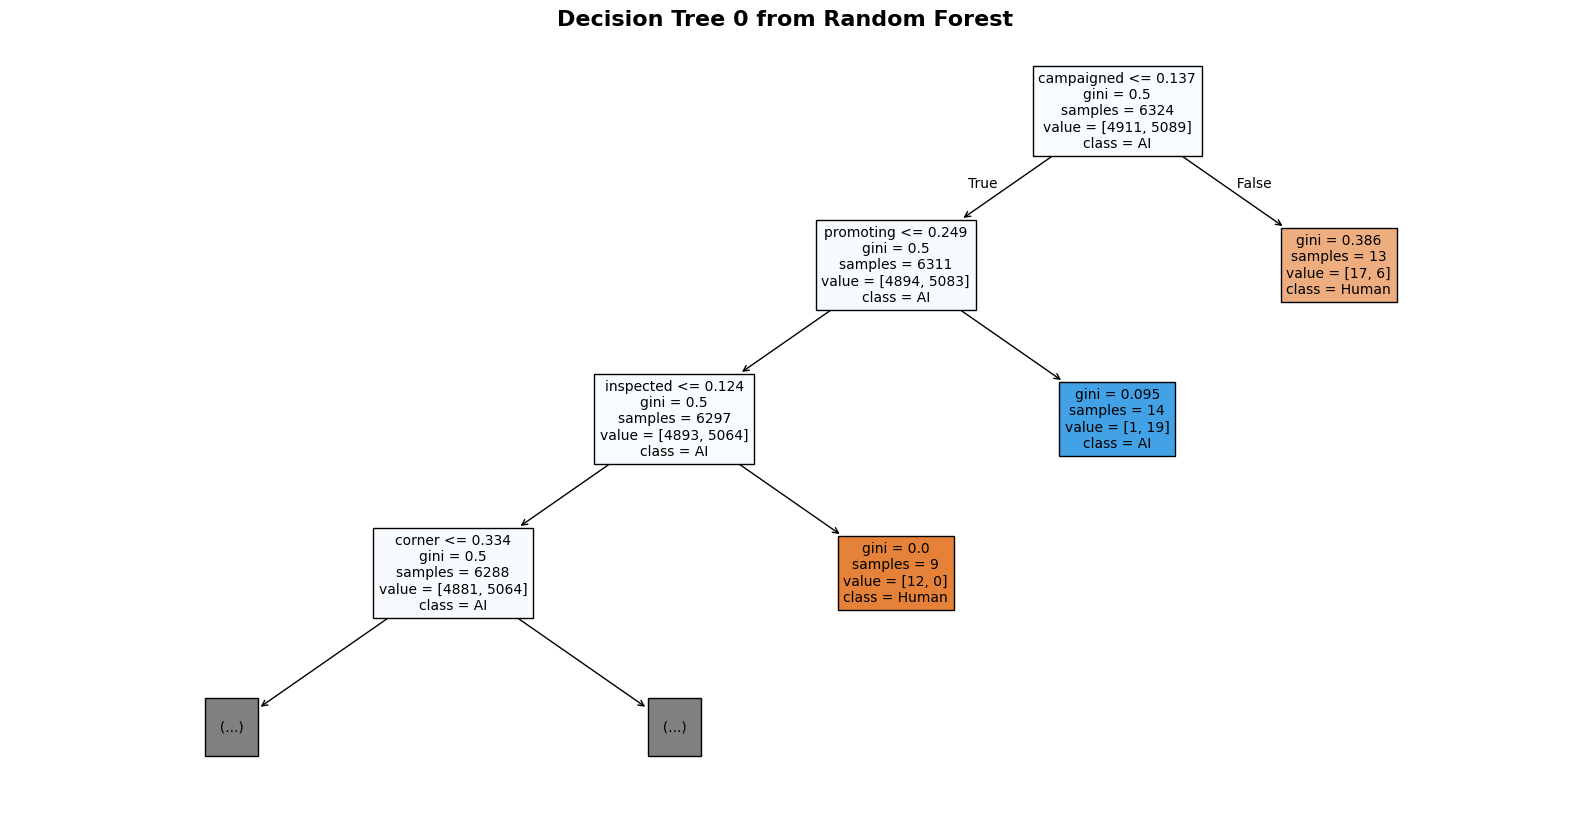

In [ ]:
estimator = rf_model_best.estimators_[0]  # get first tree from the forest

plt.figure(figsize=(20, 10))
plot_tree(
    estimator,
    max_depth=3,                 # you can increase this, but it'll get crowded
    feature_names=tfidf.get_feature_names_out(),
    class_names=["Human", "AI"],
    filled=True,
    fontsize=10
)
plt.title("Decision Tree 0 from Random Forest", fontsize=16, fontweight="bold")
plt.show()

## The root node is checking:
👉 Does the TF-IDF value of the word "campaigned" ≤ 0.137?
TF-IDF tells us how "important" the word "campaigned" is in a given document (based on frequency and rarity across all documents)


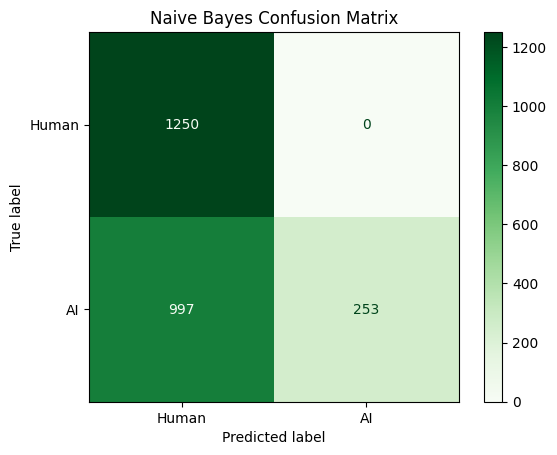

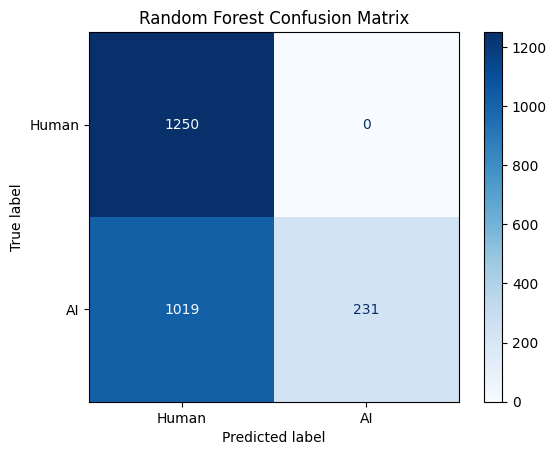

In [ ]:
# Naive Bayes predictions
nb_preds = model_baye.predict(val_X_tfidf)


# Random Forest predictions
rf_preds = rf_model_best.predict(val_X_tfidf)

# Naive Bayes Confusion Matrix
nb_cm = confusion_matrix(val_y, nb_preds)
disp_nb = ConfusionMatrixDisplay(confusion_matrix=nb_cm, display_labels=["Human", "AI"])
disp_nb.plot(cmap='Greens')
plt.title("Naive Bayes Confusion Matrix")
plt.show()

# Random Forest Confusion Matrix
rf_cm = confusion_matrix(val_y, rf_preds)
disp_rf = ConfusionMatrixDisplay(confusion_matrix=rf_cm, display_labels=["Human", "AI"])
disp_rf.plot(cmap='Blues')
plt.title("Random Forest Confusion Matrix")
plt.show()

## Process and test on test dfs

In [ ]:

def evaluate_models_on_test(test_df, model_baye, rf_model, tfidf, name="Test Set"):
    print(f"\n📊 Evaluating on {name}...")

    # Preprocessing
    X = test_df['processed_text'].fillna("")
    y = test_df['label']
    X_tfidf = tfidf.transform(X)

    # Naive Bayes
    nb_preds = model_baye.predict(X_tfidf)
    nb_acc = accuracy_score(y, nb_preds)
    print(f"\n🔹 Naive Bayes Accuracy: {nb_acc:.4f}")
    print(classification_report(y, nb_preds, target_names=["Human", "AI"]))

    # Random Forest
    rf_preds = rf_model.predict(X_tfidf)
    rf_acc = accuracy_score(y, rf_preds)
    print(f"\n🔹 Random Forest Accuracy: {rf_acc:.4f}")
    print(classification_report(y, rf_preds, target_names=["Human", "AI"]))


In [ ]:
test_sets = {
    "test_01": test_01,
    # "test_02": test_02,
    # "test_03": test_03,
    "test_02": test_04,
    "test_03": test_05
}

for name, df in test_sets.items():
    evaluate_models_on_test(df, model_baye, rf_model_best, tfidf, name)



📊 Evaluating on test_01...

🔹 Naive Bayes Accuracy: 0.8740
              precision    recall  f1-score   support

       Human       0.87      0.88      0.87       250
          AI       0.88      0.87      0.87       250

    accuracy                           0.87       500
   macro avg       0.87      0.87      0.87       500
weighted avg       0.87      0.87      0.87       500


🔹 Random Forest Accuracy: 0.8080
              precision    recall  f1-score   support

       Human       0.80      0.83      0.81       250
          AI       0.82      0.79      0.80       250

    accuracy                           0.81       500
   macro avg       0.81      0.81      0.81       500
weighted avg       0.81      0.81      0.81       500


📊 Evaluating on test_02...

🔹 Naive Bayes Accuracy: 0.7760
              precision    recall  f1-score   support

       Human       0.81      0.72      0.76       250
          AI       0.75      0.84      0.79       250

    accuracy                

In [ ]:


def plot_conf_matrices(test_sets, model_baye, rf_model, tfidf):
    fig, axes = plt.subplots(nrows=3, ncols=2, figsize=(12, 25))

    for i, (name, df) in enumerate(test_sets.items()):
        # Preprocess
        X = df['processed_text'].fillna("")
        y = df['label']
        X_tfidf = tfidf.transform(X)

        # Naive Bayes
        nb_preds = model_baye.predict(X_tfidf)
        nb_cm = confusion_matrix(y, nb_preds)
        nb_acc = accuracy_score(y, nb_preds)

        disp_nb = ConfusionMatrixDisplay(nb_cm, display_labels=["Human", "AI"])
        disp_nb.plot(ax=axes[i, 0], cmap='Greens', values_format='d')
        axes[i, 0].set_title(f"{name} - Naive Bayes\nAcc: {nb_acc:.3f}")

        # Random Forest
        rf_preds = rf_model.predict(X_tfidf)
        rf_cm = confusion_matrix(y, rf_preds)
        rf_acc = accuracy_score(y, rf_preds)

        disp_rf = ConfusionMatrixDisplay(rf_cm, display_labels=["Human", "AI"])
        disp_rf.plot(ax=axes[i, 1], cmap='Blues', values_format='d')
        axes[i, 1].set_title(f"{name} - Random Forest\nAcc: {rf_acc:.3f}")

    plt.tight_layout()
    plt.show()


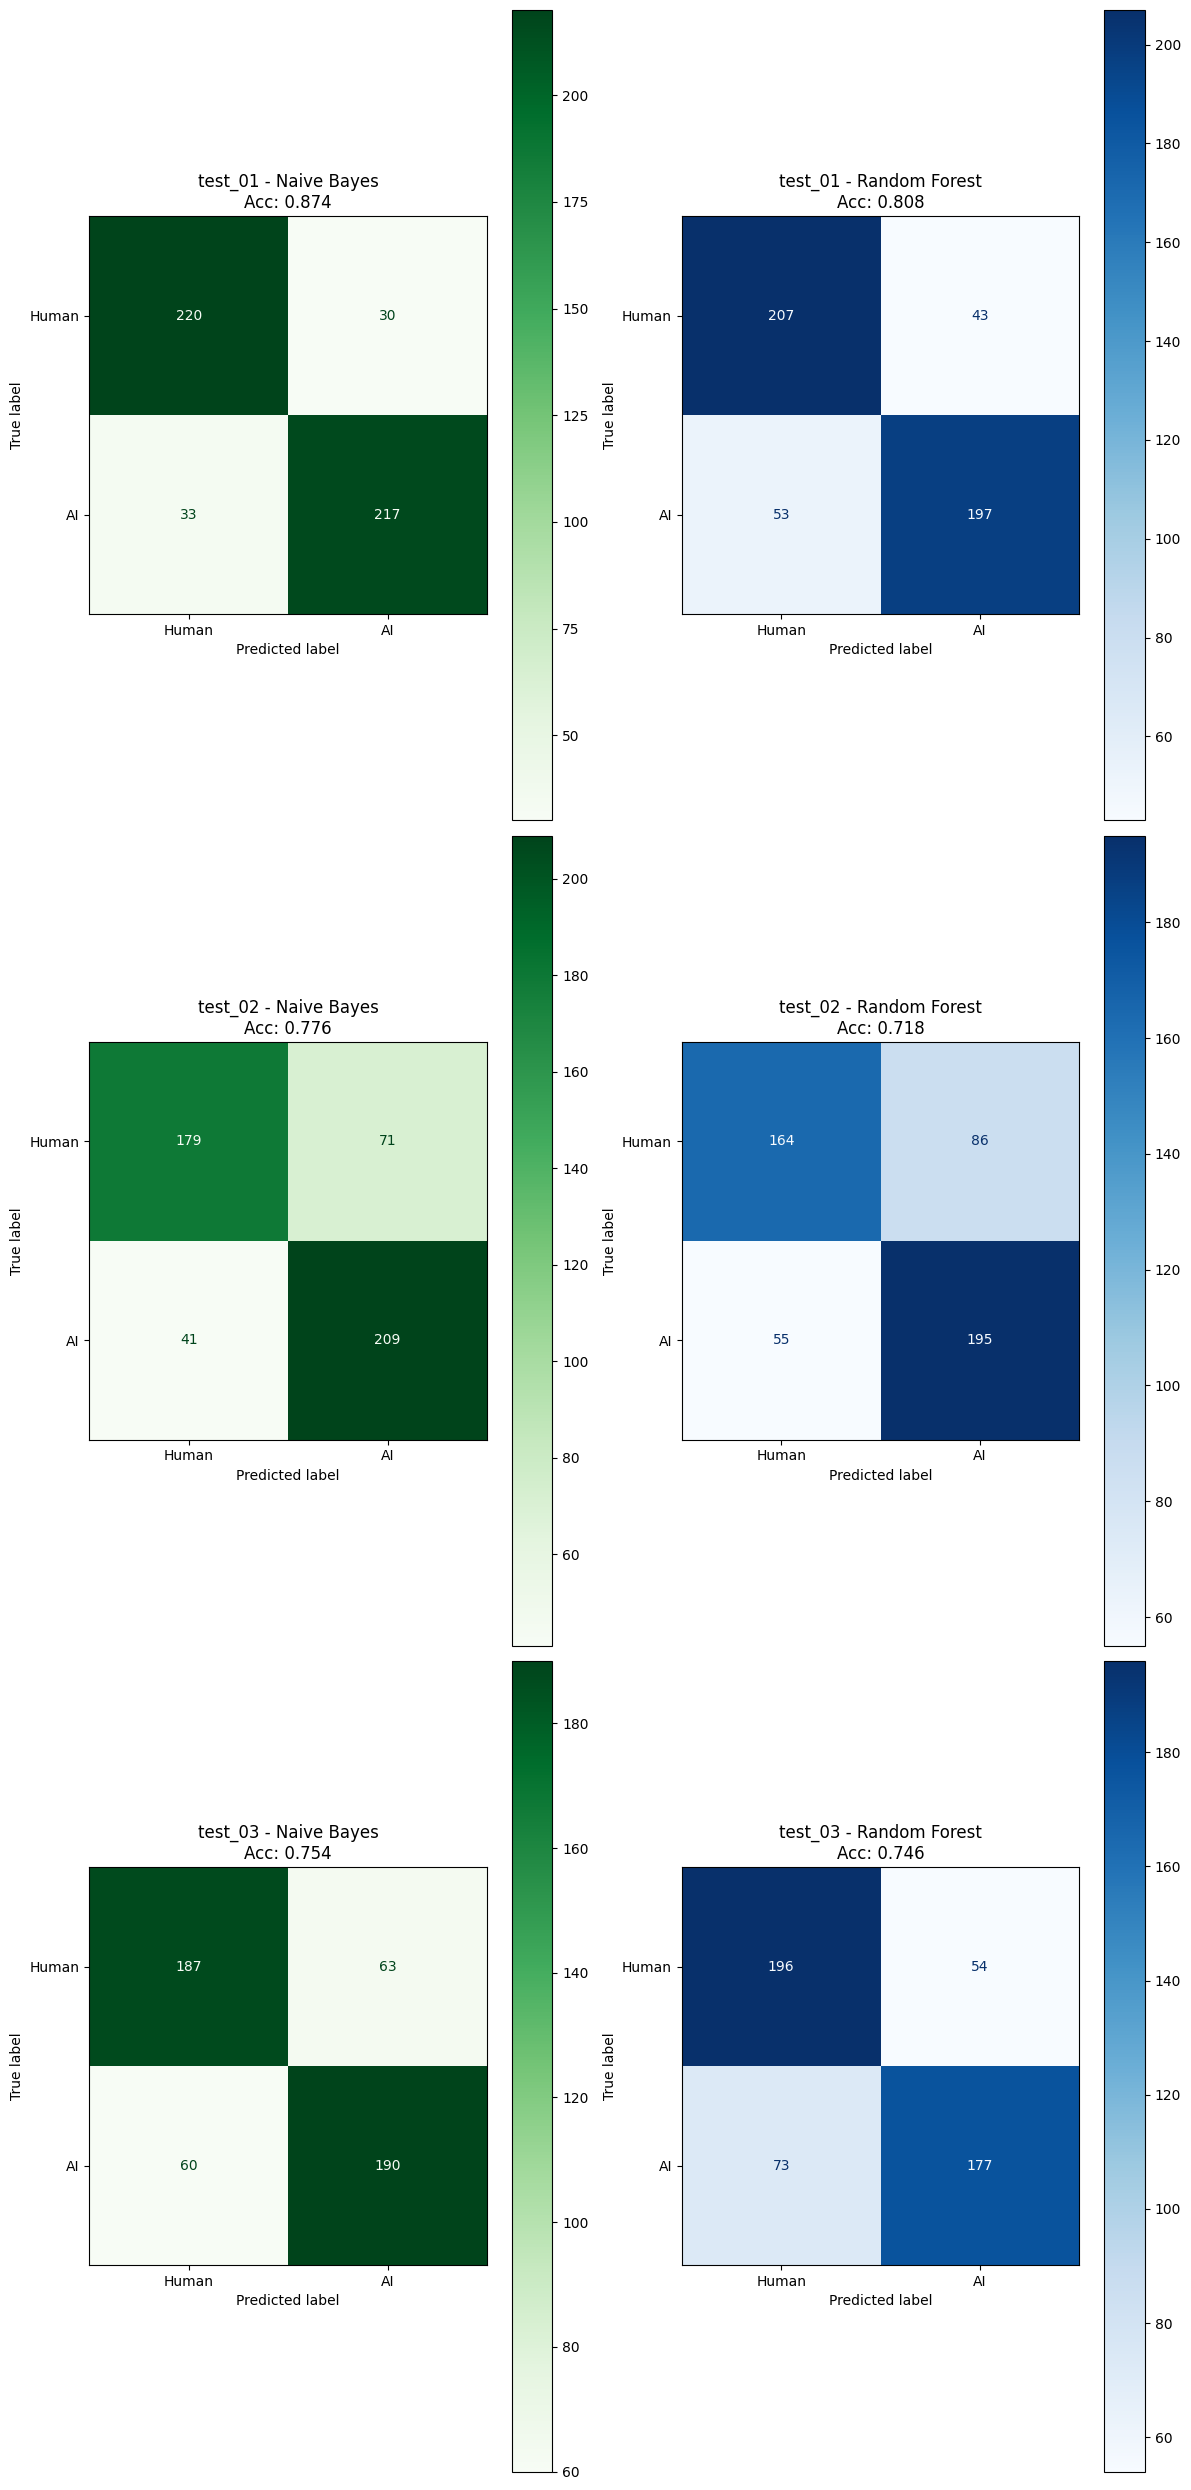

In [ ]:
test_sets = {
    "test_01": test_01,
    "test_02": test_04,
    "test_03": test_05
}
# ny times + midjourney
# 4: bbc + sdxl
# cnn + sdxl
plot_conf_matrices(test_sets, model_baye, rf_model_best, tfidf)


In [ ]:
def plot_top_rf_features(rf_model, tfidf_vectorizer, top_n=20):
    """
    Plot the top N most important features (words) based on a trained Random Forest model.

    Parameters:
    - rf_model: trained RandomForestClassifier model
    - tfidf_vectorizer: the fitted TfidfVectorizer used for training
    - top_n: how many top features to display (default = 20)
    """
    import numpy as np
    import matplotlib.pyplot as plt

    # Get feature importances and names
    importances = rf_model.feature_importances_
    indices = np.argsort(importances)[-top_n:]  # indices of top features
    feature_names = np.array(tfidf_vectorizer.get_feature_names_out())[indices]
    importance_values = importances[indices]

    # Plot
    plt.figure(figsize=(10, 6))
    plt.barh(feature_names, importance_values)
    plt.title("Top Words that Influence AI Predictions", fontweight="bold")
    plt.xlabel("Importance Score")
    plt.tight_layout()
    plt.show()


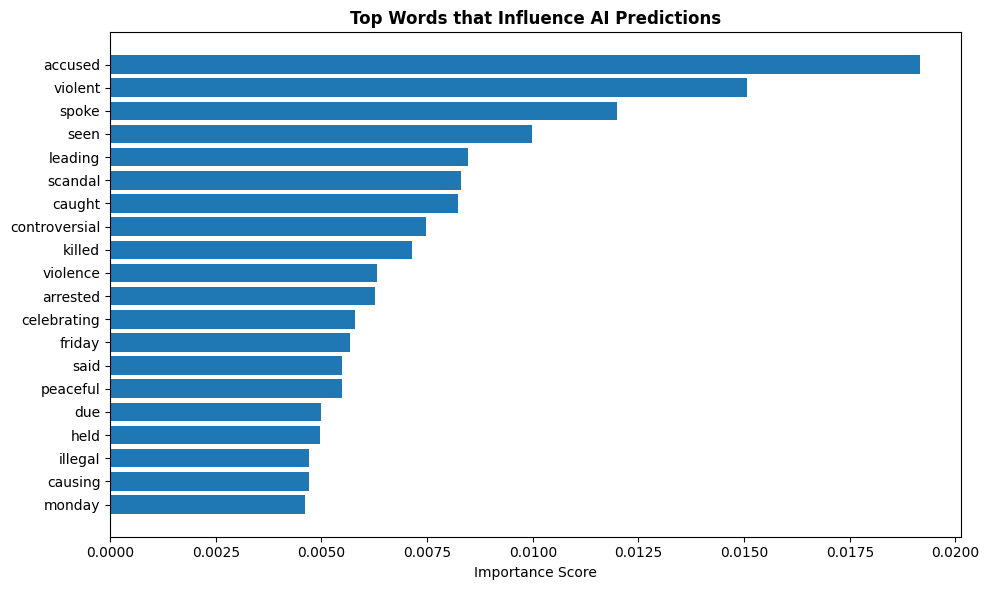

In [ ]:
plot_top_rf_features(rf_model_best, tfidf)


word  importance
398         accused    0.019161
9513        violent    0.015073
8387          spoke    0.011987
8025           seen    0.009974
5307        leading    0.008471
7965        scandal    0.008309
1675         caught    0.008219
2016  controversial    0.007474
5095         killed    0.007138
9512       violence    0.006304
906        arrested    0.006260
1688    celebrating    0.005790
3610         friday    0.005672
7916           said    0.005498
7024       peaceful    0.005488
2806            due    0.004981
4188           held    0.004963
4443        illegal    0.004710
1678        causing    0.004701
6204         monday    0.004615